In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Rene neural simples de camada única com regressão linear

<a href="https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%204%20-%20S%2BP/S%2BP%20Week%202%20Lesson%202.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.7.0-dev20210819


In [16]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

#Separação entre dados de treinamento e dados de validação
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [17]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  ''' O tamanho da janela que queremos
  O tamanho dos lotes a serem usados no treinamento(batch)
  O tamanho do buffer que determina como os dados são embaralhados
  drop_remainder=True seria todos do mesmo tamanho 
  Para um dataset grande o shuffle_buffer acelera as coisas'''
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  # Divide então o dataset em x = todos os elementos menos o ultimo, e o y que é o ultimo elemento
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [18]:
#Este codigo faz a regressão linear simples
#Pegar os valores de treinamento
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(dataset)

#Unica camada sendo sua forma de entrada o tamanho da janela
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])

#Coloco em modelo sequencial contendo uma unica camada
model = tf.keras.models.Sequential([l0])

#Ajustar o modelo
#mse = a perda de erro quadrada média
#otimizador usará Stochastic Gradient Descent. Eu usaria essa metodologia em vez 
#da string bruta, para que eu possa definir parâmetros para inicializá-lo, como 
#a taxa de aprendizagem ou LR e o momentum. Experimente com valores diferentes aqui 
#para ver se você consegue seu modelo para convergir mais rapidamente ou com mais precisão.
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))

#Ajustar o modelo passando o conjunto de dados
# definido anteriormente e serão 100 épocas
model.fit(dataset,epochs=100,verbose=0)

#Ver os diferentes pesos
print("Layer weights {}".format(l0.get_weights()))

'''Comentarios adicionais sobre a saida no documento'''

<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float32, tf.float32)>
Layer weights [array([[-9.37976018e-02],
       [ 1.46944644e-02],
       [ 5.99550977e-02],
       [ 3.26083333e-04],
       [ 1.71306096e-02],
       [ 4.00452763e-02],
       [-1.15578361e-02],
       [-9.10776854e-02],
       [ 8.18782747e-02],
       [-4.08646427e-02],
       [ 2.82692425e-02],
       [ 3.21986564e-02],
       [-7.49351978e-02],
       [-1.71009470e-02],
       [ 1.11680804e-02],
       [ 1.13059096e-01],
       [ 6.23753592e-02],
       [ 1.75471246e-01],
       [ 2.37033129e-01],
       [ 4.37768102e-01]], dtype=float32), array([0.01335682], dtype=float32)]


'Comentarios adicionais sobre a saida no documento'

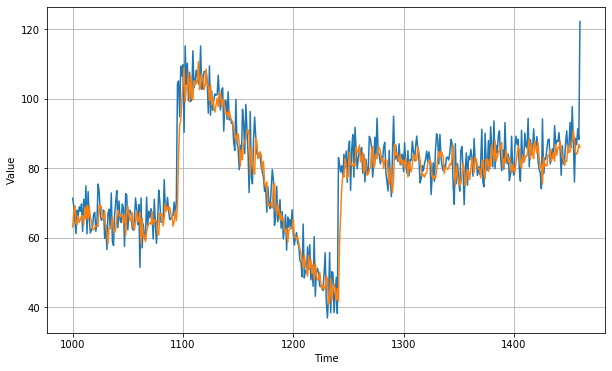

In [19]:
'''
se quisermos traçar nossas previsões para cada ponto em a série 
temporal em relação a os 20 pontos anteriores, onde o tamanho da nossa 
janela era 20, podemos escrever código como este
'''

forecast = []

#repita a série pegando fatias e tamanho da janela, predizê-los e adicionar os resultados para a lista de previsão. 
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

#Tínhamos dividido nossa série temporal no sentido de treinamento e teste levando tudo antes de um certo tempo é treinamento e o resto é validação
forecast = forecast[split_time-window_size:]
#apenas pegar as previsões depois o tempo dividido e carga -los em uma matriz NuimPy para gráficos. 
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

#Valores reais em azul
#Valores previstos em Laranja

In [20]:
#erro médio absoluto
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.04559